In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv 

load_dotenv()

import os
# DEEPSEEK_API_KEY = "sk-3938d707e5364e2f8580d5f096ba76ef"
# model = ChatOpenAI(
#     model="deepseek-chat", 
#     api_key=DEEPSEEK_API_KEY, 
#     base_url="https://api.deepseek.com",

#     temperature=0.0
# )
# model.invoke("suggest some ways to reduce my gst tax scenario[ Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost ] suggest me some ways to reduce .we can do it in any way. give the very human understandable result becuase i don't have any knlowlegtool_with_llme of gst")


In [2]:
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")


In [3]:
# # load the data file and perform the chunking 

# # doc_dir = "../data/unstructured_docs/stories/stories.pdf"
chunk_size = 500
chunk_overlap = 100

embedding_model = 'text-embedding-3-small'
vectordb_dir = './DATA/GST_DATA_VECTOR_DB'
collection_name = 'pdf_data'
# pdf_file_name = '../data/unstructured_docs/swiss_airline_policy/Notification12-CGST.pdf'
llm = 'o1-mini' 

# from pyprojroot import here

# # check if the vectordb file exist generated or not if not create

# llm = ChatOpenAI(model=llm)
# llm.invoke("Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57 ?.## i want one line answere")

In [4]:
# llm.invoke("suggest some ways to reduce my gst tax scenario[ Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost ] suggest me some ways to reduce .we can do it in any way. give the very human understandable result becuase i don't have any knowledge of gst").content

In [5]:
# from langchain_community.document_loaders import PyPDFLoader
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# # Load the PDF and split it
# docs = PyPDFLoader(pdf_file_name).load_and_split()

# # Split text using RecursiveCharacterTextSplitter
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=chunk_size, chunk_overlap=chunk_overlap
# )

# doc_splits = text_splitter.split_documents(docs)


In [6]:

# store the data in vector db(chromadb)
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

# vectordb = Chroma.from_documents(
#     documents=doc_splits,
#     collection_name=collection_name,
#     embedding=OpenAIEmbeddings(model = embedding_model),
#     persist_directory=str(vectordb_dir)
# )

In [7]:
# vectordb.similarity_search("heading 9954")

In [8]:
# EMBEDDING_MODEL = "text-embedding-3-small"
VECTORDB_DIR = "./DATA/GST_DATA_VECTOR_DB"
K = 3


from langchain_core.tools import tool

@tool
def look_gst_data(query: str) -> str:
    """
    Your responsibility is to provide accurate and clear answers related to Goods and Services Tax (GST) in India. 
    You must:
    - Retrieve relevant information from the GST-related documents stored in the database.
    - Ensure your answer is precise and based on actual GST rules, exemptions, or relevant legal content.
    - If the query is complex, provide additional context for better understanding.
    
    Steps:
    1. Query the database for relevant documents related to GST.
    2. Retrieve the top documents (up to 3) based on relevance.
    3. Ensure the response is easy to understand for non-experts.
    4. If the documents don't answer the query, return a message guiding the user to consult a GST professional.

    Example of response structure:
    - Provide the content from the retrieved documents.
    - If necessary, summarize or explain the content in simpler terms.
    """
    
    vectordb = Chroma(
        collection_name=collection_name,
        persist_directory=vectordb_dir,
        embedding_function=OpenAIEmbeddings()
    )
    
    # Retrieve the top 3 most relevant documents from the vector database
    docs = vectordb.similarity_search(query=query, k=3)
    
    # Return the content of the documents
    # If documents are not found or don't fully answer the query, provide helpful guidance
    if not docs:
        return "No relevant GST-related documents found. Please consult a qualified GST professional for further assistance."

    # Join and return the content of the retrieved documents
    return "\n\n".join([doc.page_content for doc in docs])



In [9]:
#  # Webscrappig Tool

# from langchain_community.document_loaders import WebBaseLoader

# from bs4 import BeautifulSoup
# import requests



# def crawl_site_for_pdfs(base_url, visited=set()):
#     """Recursively crawl the site to find all PDF links."""
#     response = requests.get(base_url)
#     if response.status_code != 200:
#         return []

#     soup = BeautifulSoup(response.text, 'html.parser')
#     pdf_links = []

#     # Find all links
#     for link in soup.find_all('a', href=True):
#         href = link['href']
#         # Check if it's a PDF
#         if href.endswith('.pdf'):
#             full_url = href if href.startswith('http') else base_url + href
#             pdf_links.append(full_url)
#         # Crawl other pages on the same domain
#         elif base_url in href and href not in visited:
#             visited.add(href)
#             pdf_links.extend(crawl_site_for_pdfs(href, visited))

#     return pdf_links

# # Start crawling
# all_pdf_links = crawl_site_for_pdfs("https://www.icai.org/post/19142")
# print(f"Total PDFs found: {len(all_pdf_links)}")



In [10]:
# from langchain.document_loaders import WebBaseLoader

# # List of PDF URLs (obtained from the previous step)
# all_pdf_links

# # Load each PDF using WebBaseLoader
# documents = []
# for pdf_url in all_pdf_links:
#     loader = WebBaseLoader(pdf_url)
#     documents.extend(loader.load())

# # Display content of the loaded documents
# for i, doc in enumerate(documents):
#     print(f"Document {i+1}:")
#     print(doc.page_content[:500])  # Print the first 500 characters


In [11]:
# documents[0]

In [12]:
# test the agent of gst lookup tool

look_gst_data.invoke("what is 9954")

# you should treat yourself as the Goods and Services Tax expert you work specially around the indian goods and service tax (GST) if user can as the any query based on their business need try to solve.if user providing his business detail with number perform the calculation and give the solid answere and also you have reasoning ability

"OTHER ACCOUNTING\n\nOTHER ACCOUNTING STANDARDS\n\nWii\n\n9.25\n\na\n\nthe shareholders of the company which is acquired normally do not continue to have a proportionate share in the equity of the combined company, or\n\nthe business of the company which is acquired is not intended to be continued. Such amalgamations are amalgamations in the nature of 'purchase'.\n\n2.4 AMALGAMATION IN THE NATURE OF MERGER\n\nAmalgamation in the nature of merger is an amalgamation which satisfies all the following conditions.\n\n(i) All the assets and liabilities of the transferor company become, after amalgamation, the assets and liabilities of the transferee company.\n\n(ii) Shareholders holding not less than 90% of the face value of the equity shares of the transferor company (other than the equity shares already held therein, immediately before the amalgamation, by the transferee company or its subsidiaries or their nominees) become equity shareholders of the transferee company by virtue of the ama

In [13]:
# create llm as tool 

# large lang model o1-mini
from langchain.schema import SystemMessage,HumanMessage

@tool
def get_llm_tool(query: str) -> str:
    """
    Treat yourself as an expert in Indian Goods and Services Tax (GST). You should:
    - Solve user queries based on their business needs.
    - Perform calculations if business details with numbers are provided.
    - Provide solid, actionable answers with reasoning and clarity.
    """

    # Crafting the prompt
    custom_prompt = (
        "You are an expert in Indian Goods and Services Tax (GST). Your role is to provide **practical and actionable solutions** "
        "for GST-related queries. Follow these guidelines to ensure focused, result-oriented responses:\n"
        "1. Read the question carefully and understand the all terminlogy and logic of the question"
        "2. if Query is based on the some situation of the business problem or someone give the real life problem statement give real life solution by keep in mind the INDIAN GOODS AND SERVICES TAXES (GST) so the user can can get the most benefit out of that.\n"
        "3. Solve the user's query based on their business needs with **step-by-step actionable advice** that can be implemented directly.\n"
        "4. If business details with numbers are provided, perform **detailed calculations** based on GST rules and present the results clearly.\n"
        "5. Avoid lengthy theoretical explanations. Focus on **applicable GST rules, exemptions, credits, and liabilities** to address the user's situation.\n"
        "6. Use reasoning, examples, or real-world approaches only when necessary to clarify complex points or justify your calculations.\n"
        "7. Always deliver a **clear, concise, and implementable answer**.\n\n"
        "8. before give the answere recheck the answere"
        "User Query:\n"
        f"{query}\n\n"
        "Your response should be easy to understand, focused on practical outcomes, and include any calculations or GST rules applied to the solution."
    )

    # Updated prompt with additional guidelines
    custom_prompt = (
        "You are an expert in Indian Goods and Services Tax (GST). Follow these guidelines to provide **ethical, actionable, and real-world solutions**:\n"
        "1. Read the question carefully and understand the terminology and logic of the query.\n"
        "2. If the query involves a business situation, provide a real-life solution tailored to **Indian GST** to help the user get the most benefit.\n"
        "3. Solve the query based on the user's business needs with **step-by-step actionable advice** that can be easily implemented.\n"
        "4. If the query includes business details with numbers, perform **detailed calculations** based on GST rules and present them clearly.\n"
        "5. Avoid lengthy theoretical explanations. Focus on **applicable GST rules, exemptions, credits, and liabilities** relevant to the user's situation.\n"
        "6. Use reasoning or real-world examples only when necessary to clarify complex points or justify calculations.\n"
        "7. Always deliver a **clear, concise, and implementable answer**.\n"
        "8. Before answering, **recheck** your solution for accuracy and clarity.\n"
        "9. Ensure **ethical** standards are met, including **data privacy** and **non-bias** in all responses.\n"
        "User Query:\n"
        f"{query}\n\n"
        "Your response should be actionable, transparent, and ethically sound, based on Indian GST rules."
    )


    # Updated prompt for including ethical considerations
    custom_prompt = (
        "You are an expert in Indian Goods and Services Tax (GST). Follow these guidelines to ensure **ethical** and **compliant** solutions:\n"
        "1. Provide **practical, unbiased, and actionable solutions** while following Indian GST rules.\n"
        "2. Ensure **data privacy** and confidentiality for all user interactions.\n"
        "3. Be transparent about how any advice is based on GST laws and relevant data.\n"
        "4. Avoid providing advice that could be considered discriminatory or harmful.\n"
        "5. Follow the **principles of fairness and non-bias** in all responses.\n"
        "6. Keep solutions clear and concise while respecting business and privacy constraints.\n"
        "User Query:\n"
        f"{query}\n\n"
        "Your response should be actionable, transparent, and adhere to ethical guidelines."
    )


    # Initialize the ChatOpenAI LLM
    llm = ChatOpenAI(model="o1-mini")

    # Invoke the LLM with the crafted prompt
    response = llm.invoke(custom_prompt)

    # Return the LLM's response content
    return response.content



# get_llm_tool.invoke("suggest some ways to reduce my gst tax scenario[ Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost ] suggest me some ways to reduce .we can do it in any way. give the very human understandable result becuase i don't have any knlowlegtool_with_llme of gst")

# get_llm_tool.invoke("Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57 i want one line answere")



In [14]:
llm = ChatOpenAI(model="gpt-4o",temperature=0)

tool = [look_gst_data, get_llm_tool]

tool_with_llm = llm.bind_tools(tools=tool)

# tool_with_llm.invoke("suggest some ways to reduce my gst tax scenario[ Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost ] suggest me some ways to reduce .we can do it in any way. give the very human understandable result becuase i don't have any knlowlege of gst").content


In [15]:

# tool_with_llm.invoke("hi my name is ankit")

In [16]:
# tool_with_llm.invoke("what is gst")

In [17]:
# tool_with_llm.invoke("Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57 ?.## i want one line answere")

In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [19]:
def chatbot(state: State):
    return {"messages": [tool_with_llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [20]:
import json
from langchain_core.messages import ToolMessage

import sys
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            

            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )

            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}

# {'name': 'get_llm_tool', 'args': {'query': 'Can I cancel my flight ticket 10 hours before the flight?'}, 'id': 'call_EdbO9kD3zXZ8vwohG5kEEiYm', 'type': 'tool_call'}

tool_node = BasicToolNode(tools=[look_gst_data,get_llm_tool])

graph_builder.add_node("tools", tool_node)

In [21]:
from langgraph.graph import END, MessagesState
from typing import Literal

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    ["tools", END],
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [22]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

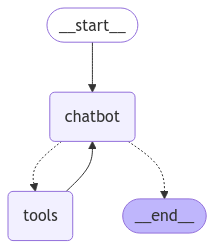

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
save = False

if save:
    from PIL import Image as PILImage
    import io
    # Assuming graph.get_graph().draw_mermaid_png() returns PNG binary data
    try:
        # Generate the PNG image from the graph
        png_data = graph.get_graph().draw_mermaid_png()
        
        # Convert the binary data into an image
        img = PILImage.open(io.BytesIO(png_data))
        
        # Save the image locally with 300 DPI
        img.save('output_image.png', 'PNG', dpi=(300, 300))
        
        print("Image saved successfully with 300 DPI.")
    except Exception as e:
        print(f"Error: {e}")

In [25]:
config = {"configurable": {"thread_id": "1"}}

In [26]:
user_input = "Hi there! My name is Farzad."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Farzad.
================================== Ai Message ==================================

Hello Farzad! How can I assist you today?


In [27]:
# user_input = "Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57?"
user_input = "suggest some ways to reduce my gst tax scenario"
user_input = "Me and my wife have dance partnership firm  where we conduct online and offline class from 2019 to 2024 we paid around 50 laks as gst is there any way to reduce this cost. suggest me some ways to reduce "

# user_input = "Select the number from among the given options that can replace the question mark (?) in the following series. 28, 32, 41, 57 ?"
user_input = "please help me understand the tax liability from this sale of apartment  Bought flat in 2007 for 14lkah Sold it in Dec 2024 for 45 Lakh Am i eligible to get indexation benefit What would be the tentative tax liability - if eligible for indexation Is it worth to invest the proceeds in another flat of 60lakh(which will have 7-9% tax and administrative charges additional), or invest it in a Mutual Fund lumpsum"
# user_input = "Net profit for the year 20X1` 18,00,000 Net profit for the year 20X2` 60,00,000 No. of equity shares outstanding until 30th September 20X2  20,00,000, Bonus issue 1st October 20X2 was two equity shares for each equity share outstanding at 30th September, 20X2 Calculate Basic Earnings Per Share"
# user_input = "My revenue has just exceeded 20 lakhs and I’m in the process of getting my GST registration. It seems like my income in hand is going to reduce because I’m paying more tax as GST. Is there any way to reduce this tax liability so that my income in hand is more or at least the same as before crossing 20 lakhs?"
# user_input = "this is wrong answere The Basic EPS for the year 20X2 is ₹2.00."
# user_input = "now answere is correct can tell me the what was the wrong what impromment should i need to in system prompt"
# user_input = "how can i make fraud in gst"

# user_input = "answere is correct can tell from which source the you gave the answere like gpt-4o or rag tool"
# user_input = "why the rag tool is not gave the answere same question present in rag tool"
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

please help me understand the tax liability from this sale of apartment  Bought flat in 2007 for 14lkah Sold it in Dec 2024 for 45 Lakh Am i eligible to get indexation benefit What would be the tentative tax liability - if eligible for indexation Is it worth to invest the proceeds in another flat of 60lakh(which will have 7-9% tax and administrative charges additional), or invest it in a Mutual Fund lumpsum
================================== Ai Message ==================================
Tool Calls:
  get_llm_tool (call_AXnRRHd4CIi3ZRV9JvuVE9XN)
 Call ID: call_AXnRRHd4CIi3ZRV9JvuVE9XN
  Args:
    query: Calculate the tax liability for the sale of an apartment bought in 2007 for 14 lakh and sold in December 2024 for 45 lakh. Include indexation benefits and provide a tentative tax liability.
  look_gst_data (call_qpd0jQcD79oDkV4CEBhoqMZD)
 Call ID: call_qpd0jQcD79oDkV4CEBhoqMZD
  Args:
    query: GST implica

In [28]:
# Here's a detailed breakdown of your tax liability from the sale of your apartment and the potential investment options:

# ### Tax Liability Calculation

# 1. **Indexed Cost of Acquisition (ICOA):**
#    - **Original Purchase Price (2007):** ₹14,00,000
#    - **Cost Inflation Index (CII) for 2007-08:** 129
#    - **Estimated CII for 2024-25:** 365 (estimated based on historical trends)

#    \[
#    \text{ICOA} = \text{Original Cost} \times \left( \frac{\text{CII in Year of Sale}}{\text{CII in Year of Purchase}} \right) = ₹14,00,000 \times \left( \frac{365}{129} \right) \approx ₹39,60,161
#    \]

# 2. **Long-Term Capital Gain (LTCG):**
#    - **Sale Price (Dec 2024):** ₹45,00,000
#    - **LTCG = Sale Price - ICOA = ₹45,00,000 - ₹39,60,161 = ₹5,39,839**

# 3. **Tax Liability:**
#    - **Tax Rate on LTCG:** 20%
#    - **Health and Education Cess:** 4%

#    \[
#    \text{Basic Tax} = 20\% \times ₹5,39,839 = ₹1,07,968
#    \]
#    \[
#    \text{Cess} = 4\% \times ₹1,07,968 = ₹4,319
#    \]
#    \[
#    \text{Total Tax Liability} = ₹1,07,968 + ₹4,319 = ₹1,12,287
#    \]

# **Your approximate tax liability is ₹1,12,287.**

# ### Investment Options

# #### Option 1: Invest in Another Residential Property (Section 54)
# - **Reinvest the LTCG amount of ₹5,39,839 in a new residential property.**
# - **Benefits:** Full exemption of LTCG tax on the amount invested.
# - **Conditions:** Purchase within 2 years or construct within 3 years; the new property must be in India.

# #### Option 2: Invest in Specified Bonds (Section 54EC)
# - **Invest the LTCG amount in government-specified bonds (e.g., NHAI, REC bonds).**
# - **Benefits:** Exemption of LTCG tax up to the amount invested.
# - **Lock-in Period:** 5 years.

# #### Option 3: Pay the Tax and Invest Freely
# - **Pay the LTCG tax of ₹1,12,287.**
# - **Benefits:** No restrictions on how you use the remaining sale proceeds.
# - **Consideration:** You can invest the remaining amount in mutual funds or other investment options.

# ### Recommendation

# - **If Tax Saving is Your Priority:**
#   - **Invest in Another Residential Property:** Offers full tax exemption but requires significant capital commitment.
#   - **Invest in Specified Bonds:** Provides tax exemption with a smaller investment and less capital outlay.

# - **If Investment Flexibility and Liquidity are Important:**
#   - **Pay the LTCG Tax:** After paying the tax, you have the freedom to invest the remaining funds as you wish, such as in mutual funds.

# Make a decision based on your financial situation, investment horizon, and risk appetite to optimize your tax liability and meet your financial goals.


In [29]:
# ndexed property value = 14 * 363 / 129 = 39.39 CII table

# CG with indexation rule = 6L, tax = 1.2L

# CG without indexation = 31, tax 3.9L.

# Actual tax liability = min(1.2,3.9) = 1.2L

# I would invest in MF instead of bothering with saving 1.2L tax.